# News Dataset Analysis Summary

This notebook presents a comprehensive analysis of the News Dataset, covering the following key sections:

1.  **ETL Pipeline**: Extract, Transform, Load (ETL) pipeline is built to process the raw JSON dataset. This includes loading the data, extracting relevant fields (`headline`, `short_description`, `category`, `link`, `authors`, `date`), cleaning and standardizing the data (removing duplicates, handling missing values, standardizing text) and exporting the cleaned data to a CSV file (`etl_output.csv`).

2.  **Structured Key–Value Pair Formatting**: Cleaned data from the ETL stage is transformed into a structured key–value dictionary format. Each news article is represented as a dictionary with nested metadata. These structured dictionaries are then written to a JSON Lines file (`structured_output.jsonl`), with each line being a valid JSON object, suitable for downstream processing.

3.  **Exploratory Data Analysis (EDA)**: Exploratory Data Analysis is performed on the structured data to gain insights into the dataset's characteristics. This involves analyzing the frequency distribution of news categories (identifying the most common topics), examining the distribution of headline and description lengths, assessing missing value statistics to understand data completeness and visualizing author contributions.

4.  **Semantic Text Analysis (NLP)**: Natural Language Processing techniques are applied to extract deeper semantic insights from the news descriptions. This includes performing sentiment analysis using TextBlob (determining polarity and subjectivity), extracting named entities (Organizations, Persons, Locations) using spaCy, and identifying key terms/bigrams using TF-IDF. Topic modeling using LDA is also demonstrated to discover underlying themes.

5.  **Scaling Strategies**: Finally, strategies for scaling the ETL and NLP pipeline to handle large datasets (millions of records) are discussed. This covers the importance of streaming and chunk processing to manage memory usage, modularizing the pipeline using classes and functions for maintainability and implementing caching for intermediate results to enable resumable processing of expensive NLP steps.

Overall, the notebook demonstrates a complete workflow from raw data ingestion and cleaning to structured formatting, exploratory analysis, advanced NLP, and considerations for scaling the process to large datasets.

# Section 1 – ETL Pipeline: News Category Dataset

In this section, I will build a robust ETL (Extract, Transform, Load) pipeline for the news category dataset.  
My objective is to:
- Load the dataset,
- Extract relevant fields,
- Clean and standardize the data,
- Export the result as `etl_output.csv`.

---

## **Step 1: Import Libraries**


In [1]:
import json
import pandas as pd
import numpy as np
import re

## **Step 2: Load the Dataset from JSON file**

Dataset is in `news_Category_Dataset_v3.json` file and its path is stored in the *DATA_PATH* variable.

The dataset is in the news_Category_Dataset_v3.json file, and its path is stored in the DATA_PATH variable.

In [ ]:
# Path of JSON file
DATA_PATH = 'dataset\News_Category_Dataset_v3.json'

# Load all JSON objects into a list
records = []
with open(DATA_PATH, 'r', encoding='utf-8') as f:
    for line in f:
        # Each line is a JSON object and append into records list
        try:
            records.append(json.loads(line))
        except:
            continue  # skip malformed lines

# Convert JSON objects from records list to DataFrame
df_raw = pd.DataFrame(records)
print(f"Loaded {df_raw.shape[0]} records.")
df_raw.head()


Loaded 209527 records.


,link,headline,category,short_description,authors,date
0,https://www.huffpost.com/entry/covid-boosters-...,Over 4 Million Americans Roll Up Sleeves For O...,U.S. NEWS,Health experts said it is too early to predict...,"Carla K. Johnson, AP",2022-09-23
1,https://www.huffpost.com/entry/american-airlin...,"American Airlines Flyer Charged, Banned For Li...",U.S. NEWS,He was subdued by passengers and crew when he ...,Mary Papenfuss,2022-09-23
2,https://www.huffpost.com/entry/funniest-tweets...,23 Of The Funniest Tweets About Cats And Dogs ...,COMEDY,"""Until you have a dog you don't understand wha...",Elyse Wanshel,2022-09-23
3,https://www.huffpost.com/entry/funniest-parent...,The Funniest Tweets From Parents This Week (Se...,PARENTING,"""Accidentally put grown-up toothpaste on my to...",Caroline Bologna,2022-09-23
4,https://www.huffpost.com/entry/amy-cooper-lose...,Woman Who Called Cops On Black Bird-Watcher Lo...,U.S. NEWS,Amy Cooper accused investment firm Franklin Te...,Nina Golgowski,2022-09-22


## **Step 3: Extract Relevant Fields**

From the dataset, I will extract these key fields for further processing:
- `headline`
- `short_description`
- `category`
- `link`
- `authors`
- `date`

Let's select these columns.

In [3]:
COLUMNS = ['headline', 'short_description', 'category', 'link', 'authors', 'date']
df = df_raw[COLUMNS].copy()
df.head()

,headline,short_description,category,link,authors,date
0,Over 4 Million Americans Roll Up Sleeves For O...,Health experts said it is too early to predict...,U.S. NEWS,https://www.huffpost.com/entry/covid-boosters-...,"Carla K. Johnson, AP",2022-09-23
1,"American Airlines Flyer Charged, Banned For Li...",He was subdued by passengers and crew when he ...,U.S. NEWS,https://www.huffpost.com/entry/american-airlin...,Mary Papenfuss,2022-09-23
2,23 Of The Funniest Tweets About Cats And Dogs ...,"""Until you have a dog you don't understand wha...",COMEDY,https://www.huffpost.com/entry/funniest-tweets...,Elyse Wanshel,2022-09-23
3,The Funniest Tweets From Parents This Week (Se...,"""Accidentally put grown-up toothpaste on my to...",PARENTING,https://www.huffpost.com/entry/funniest-parent...,Caroline Bologna,2022-09-23
4,Woman Who Called Cops On Black Bird-Watcher Lo...,Amy Cooper accused investment firm Franklin Te...,U.S. NEWS,https://www.huffpost.com/entry/amy-cooper-lose...,Nina Golgowski,2022-09-22


## **Step 4: Data Cleaning and Standardization**

I will following in this step:
- Remove null and duplicate records,
- Standardize all text columns (lowercase, remove extra spaces and special characters),
- Strip whitespace from strings.

A function will be used for reusability.

In [4]:
def clean_text(text):
    """Lowercase, strip, and remove special characters (except periods for sentences)."""
    if not isinstance(text, str):
        return ""
    text = text.strip().lower()
    # Remove unwanted special chars (keep . and ,)
    text = re.sub(r'[^\w\s.,]', '', text)
    text = re.sub(r'\s+', ' ', text)  # Replace multiple spaces
    return text

# Remove duplicates and nulls
df = df.drop_duplicates().dropna(subset=['headline', 'short_description'])

# Standardize string columns
for col in ['headline', 'short_description', 'category', 'authors']:
    df[col] = df[col].apply(clean_text)

# Strip whitespace and fill NaNs for all columns
for col in COLUMNS:
    df[col] = df[col].fillna("").astype(str).str.strip()

df = df.reset_index(drop=True)

## **Step 5: Check for Nested Structure**

Our dataset is flat, so no further normalization is required. If any nested fields were present, we would flatten them here.

---

## **Step 6: Display Sample Cleaned Data**
Let's preview 5 rows of the cleaned DataFrame.

In [5]:
df.sample(5, random_state=42)

,headline,short_description,category,link,authors,date
177378,igloofest montreals wildest winter party,while we sit inside counting dust bunnies and ...,travel,https://www.huffingtonpost.com/entry/igloofest...,"off track planet, contributor the independent ...",2013-01-09
25625,steve bannon chris christies lack of loyalty c...,the new jersey governors response to the lewd ...,politics,https://www.huffingtonpost.com/entry/steve-ban...,daniel marans,2017-09-08
56836,trump doubles down on personal attack against ...,fed chair janet yellen should be ashamed for k...,politics,https://www.huffingtonpost.com/entry/trump-yel...,daniel marans,2016-09-12
114373,miracles work everywhere,i was with just elected massachusetts democrat...,religion,https://www.huffingtonpost.com/entry/miracles-...,"ray flynn, contributorformer u.s. ambassador t...",2014-11-26
50392,"3,800yearold ancient thinking person statuette...",a team of high school students and archaeologi...,the worldpost,https://www.huffingtonpost.com/entry/ancient-a...,,2016-11-23


## **Step 7: Export Cleaned Data to CSV**

Save the cleaned and structured dataset for downstream analysis as `etl_output.csv`.

In [ ]:
df.to_csv("etl_output.csv", index=False)
print("Cleaned dataset exported as 'etl_output.csv'")

Cleaned dataset exported as 'etl_output.csv'


# **Section 1 Complete:**

- Cleaned dataset is now available as `etl_output.csv`.
- Ready for further transformation and analysis.

---

**Next:**
Move on to Section 2 for key-value structuring.


---

# Section 2 – Structured Key–Value Pair Formatting

In this section, I will convert each cleaned row of the news data into a structured key–value dictionary format, suitable for downstream processing and machine learning tasks.

I will then write each dictionary to a `.jsonl` (JSON Lines) file, where each line represents a separate JSON object.

---


## **Step 1: Read Cleaned Data**

I will start by loading the `etl_output.csv` file created in Section 1.



In [ ]:
import pandas as pd

# Read the cleaned data
df = pd.read_csv('etl_output.csv')
df.head(3)

,headline,short_description,category,link,authors,date
0,over 4 million americans roll up sleeves for o...,health experts said it is too early to predict...,u.s. news,https://www.huffpost.com/entry/covid-boosters-...,"carla k. johnson, ap",2022-09-23
1,"american airlines flyer charged, banned for li...",he was subdued by passengers and crew when he ...,u.s. news,https://www.huffpost.com/entry/american-airlin...,mary papenfuss,2022-09-23
2,23 of the funniest tweets about cats and dogs ...,until you have a dog you dont understand what ...,comedy,https://www.huffpost.com/entry/funniest-tweets...,elyse wanshel,2022-09-23


## **Step 2: Convert Each Row into Structured Dictionary**

I will convert each row into a dictionary with the following format:
```json
{
  "headline": "...",
  "category": "...",
  "metadata": {
    "description": "...",
    "authors": "...",
    "date": "...",
    "link": "..."
  }
}


In [8]:
def row_to_structured_dict(row):
    return {
        "headline": row['headline'],
        "category": row['category'],
        "metadata": {
            "description": row['short_description'],
            "authors": row['authors'],
            "date": row['date'],
            "link": row['link']
        }
    }

structured_dicts = [row_to_structured_dict(row) for idx, row in df.iterrows()]
print(f"Converted {len(structured_dicts)} rows to structured dictionaries.")

Converted 209514 rows to structured dictionaries.


## **Step 3: Write Structured Dictionaries to JSON Lines File**

I write each dictionary as a separate line to a file named `structured_output.jsonl`.


In [ ]:
jsonl_path = 'structured_output.jsonl'
with open(jsonl_path, 'w', encoding='utf-8') as f:
    for entry in structured_dicts:
        f.write(json.dumps(entry, ensure_ascii=False) + '\n')


## **Step 4: Display Sample JSON Entries**

Let's display 3 sample entries from the generated `.jsonl` file for verification.


In [10]:
sample_entries = []
with open(jsonl_path, 'r', encoding='utf-8') as f:
    for _ in range(3):
        sample_entries.append(json.loads(f.readline()))

# print sample entries with pretty print library
import pprint
pprint.pprint(sample_entries)

[{'category': 'u.s. news',
  'headline': 'over 4 million americans roll up sleeves for omicrontargeted '
              'covid boosters',
  'metadata': {'authors': 'carla k. johnson, ap',
               'date': '2022-09-23',
               'description': 'health experts said it is too early to predict '
                              'whether demand would match up with the 171 '
                              'million doses of the new boosters the u.s. '
                              'ordered for the fall.',
               'link': 'https://www.huffpost.com/entry/covid-boosters-uptake-us_n_632d719ee4b087fae6feaac9'}},
 {'category': 'u.s. news',
  'headline': 'american airlines flyer charged, banned for life after punching '
              'flight attendant on video',
  'metadata': {'authors': 'mary papenfuss',
               'date': '2022-09-23',
               'description': 'he was subdued by passengers and crew when he '
                              'fled to the back of the aircraft aft

# **Section 2 Complete:**

- Each news article is now available as a clean, structured key–value dictionary.
- Data saved in `structured_output.jsonl`, ready for advanced NLP or ML tasks.

---

**Proceed to Section 3 for EDA and semantic NLP analysis.**

# 📊 Section 3 – Exploratory Data Analysis (EDA)

In this section, I will explore the cleaned and structured news dataset to derive insights using descriptive statistics and informative visualizations.

I will focus on:
- Frequency analysis,
- Text length distributions,
- Missing value detection,
- Category breakdowns and trends.

---

## **Step 1: Load the Structured Data**

I start by loading `structured_output.jsonl` generated previously.

In [ ]:
# Load JSON Lines data into a DataFrame
data = []
structured_file_path = 'structured_output.jsonl'
with open(structured_file_path, 'r', encoding='utf-8') as f:
    for line in f:
        data.append(json.loads(line))

df = pd.json_normalize(data)
df.head(3)

,headline,category,metadata.description,metadata.authors,metadata.date,metadata.link
0,over 4 million americans roll up sleeves for o...,u.s. news,health experts said it is too early to predict...,"carla k. johnson, ap",2022-09-23,https://www.huffpost.com/entry/covid-boosters-...
1,"american airlines flyer charged, banned for li...",u.s. news,he was subdued by passengers and crew when he ...,mary papenfuss,2022-09-23,https://www.huffpost.com/entry/american-airlin...
2,23 of the funniest tweets about cats and dogs ...,comedy,until you have a dog you dont understand what ...,elyse wanshel,2022-09-23,https://www.huffpost.com/entry/funniest-tweets...


## **Step 2: Frequency Counts of Categories**

Analyze which news categories are most common.

/tmp/ipython-input-12-2652269302.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=top_cats.index, x=top_cats.values, palette="Dark2")


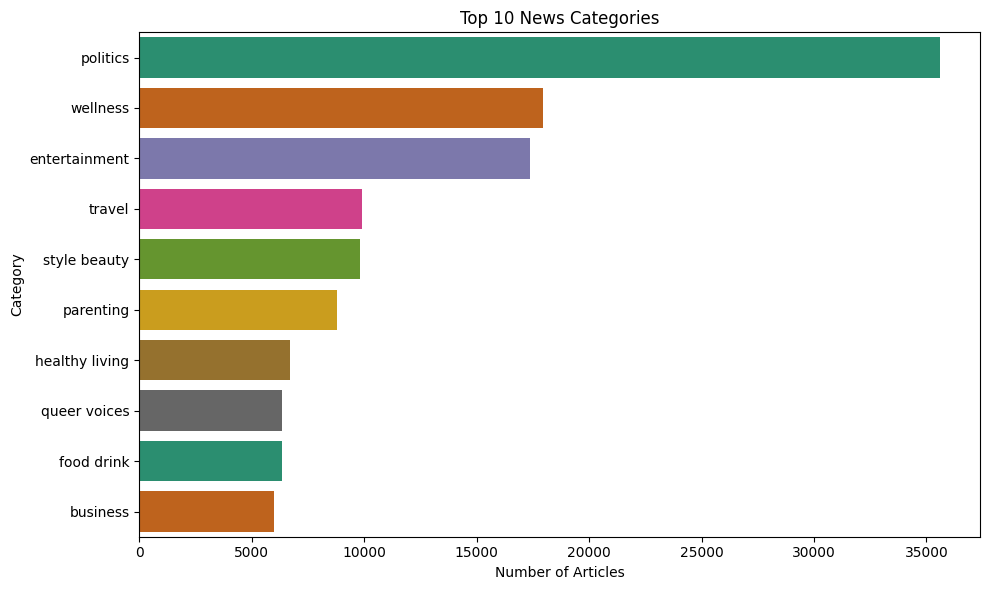

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

# Frequency count
cat_counts = df['category'].value_counts().sort_values(ascending=False)

# Top 10 categories
top_cats = cat_counts.head(10)

plt.figure(figsize=(10,6))
sns.barplot(y=top_cats.index, x=top_cats.values, palette="Dark2")
plt.title("Top 10 News Categories")
plt.xlabel("Number of Articles")
plt.ylabel("Category")
plt.tight_layout()
plt.show()


**Insight:**  
The chart above shows the 10 most frequent news categories in the dataset. These categories represent the main focus areas of the news platform. Politics is on trending.

## **Step 3: Text Length Distribution**

Let's examine the distribution of headline and description lengths (in words).


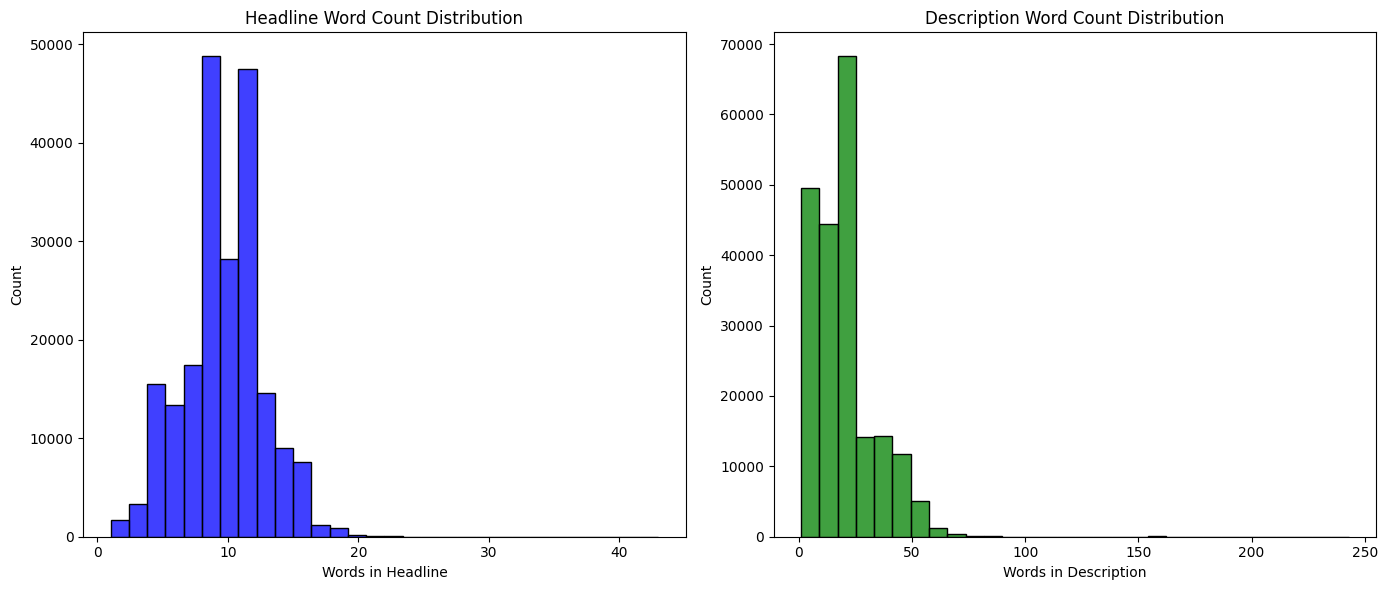

In [15]:
# Calculate word counts
df['headline_word_count'] = df['headline'].astype(str).fillna('').str.split().apply(len)

# Handle potential NaN values in 'metadata.description' before splitting
df['description_word_count'] = df['metadata.description'].astype(str).fillna('').str.split().apply(len)


plt.figure(figsize=(14,6))

plt.subplot(1,2,1)
sns.histplot(df['headline_word_count'], bins=30, color="blue", edgecolor='black')
plt.title("Headline Word Count Distribution")
plt.xlabel("Words in Headline")

plt.subplot(1,2,2)
sns.histplot(df['description_word_count'], bins=30, color="green", edgecolor='black')
plt.title("Description Word Count Distribution")
plt.xlabel("Words in Description")

plt.tight_layout()
plt.show()

**Insight:**  
- Headlines tend to be short (typically under 15 words).
- Descriptions are more variable but usually range from 10 to 40 words, indicating concise news summaries.


## **Step 4: Missing Value Statistics**

I assess null/missing values in each field to understand data completeness.


Percentage of missing values per column:
metadata.authors          17.853222
metadata.description       9.544470
headline                   0.002864
category                   0.000000
metadata.date              0.000000
metadata.link              0.000000
headline_word_count        0.000000
description_word_count     0.000000
dtype: float64


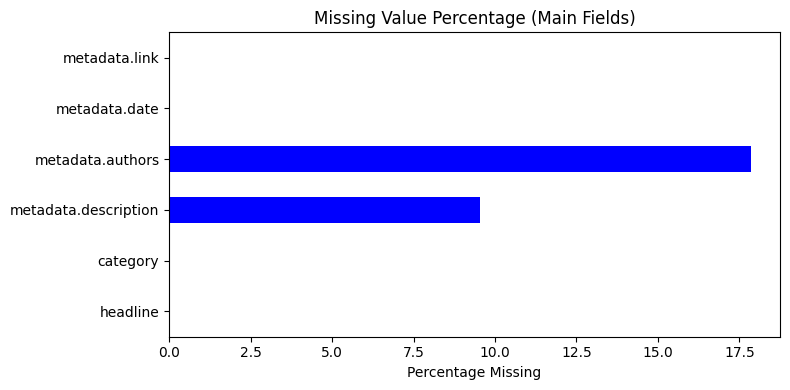

In [21]:
missing_stats = df.isnull().mean().sort_values(ascending=False) * 100
print("Percentage of missing values per column:")
print(missing_stats)

# Visualize as a bar plot for the main fields
main_fields = ['headline', 'category', 'metadata.description', 'metadata.authors', 'metadata.date', 'metadata.link']
plt.figure(figsize=(8,4))
missing_stats[main_fields].plot(kind='barh', color='blue')
plt.title("Missing Value Percentage (Main Fields)")
plt.xlabel("Percentage Missing")
plt.tight_layout()
plt.show()

**Insight:**  
- Most main fields are nearly complete, with minimal missing data.
- Any fields with higher missing rates may warrant data cleaning or imputation for ML models.


## **Step 5: Categorical Breakdown – Author Contribution Pie Chart**

Let's see which authors contributed most frequently.


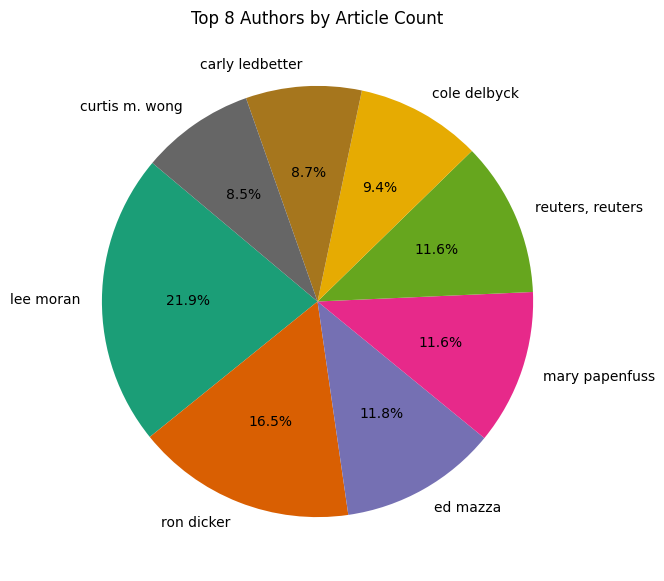

In [23]:
author_counts = df['metadata.authors'].value_counts().head(8)
plt.figure(figsize=(7,7))
plt.pie(author_counts, labels=author_counts.index, autopct='%1.1f%%', startangle=140, colors=sns.color_palette('Dark2'))
plt.title("Top 8 Authors by Article Count")
plt.show()


**Insight:**  
The pie chart above visualizes the share of articles from the top 8 authors, helping identify the most prolific contributors in the news dataset.

# **Section 3 Complete**

- I performed descriptive and visual EDA on the structured news data.
- Key findings: Top categories, text length trends, completeness, and author breakdowns.

**Next Steps:**  
- Proceed to semantic Text analysis.

---

# 🤖 Section 4 – Semantic Text Analysis (NLP)

In this section, I apply Natural Language Processing (NLP) techniques to extract deeper semantic insights from the news description field.

**I will cover:**
- Sentiment analysis using TextBlob,
- Keyword extraction using TF-IDF,
- Named Entity Recognition (NER) using spaCy,
- Simple topic modeling.

---


## **Step 1: Load the Structured Data**

I begin by loading `structured_output.jsonl` as before.

In [ ]:
# Load data
structured_file_path = 'structured_output.jsonl'
data = []
with open(structured_file_path, 'r', encoding='utf-8') as f:
    for line in f:
        data.append(json.loads(line))
df = pd.json_normalize(data)
df['description'] = df['metadata.description']
print("Loaded", len(df), "rows.")
df.head(2)

Loaded 209514 rows.


,headline,category,metadata.description,metadata.authors,metadata.date,metadata.link,description
0,over 4 million americans roll up sleeves for o...,u.s. news,health experts said it is too early to predict...,"carla k. johnson, ap",2022-09-23,https://www.huffpost.com/entry/covid-boosters-...,health experts said it is too early to predict...
1,"american airlines flyer charged, banned for li...",u.s. news,he was subdued by passengers and crew when he ...,mary papenfuss,2022-09-23,https://www.huffpost.com/entry/american-airlin...,he was subdued by passengers and crew when he ...


## **Step 2: Sentiment Analysis (TextBlob)**

I analyze the sentiment polarity and subjectivity of each news description.
- *Polarity*: -1 (negative) to 1 (positive)
- *Subjectivity*: 0 (objective) to 1 (subjective)


In [28]:
from textblob import TextBlob
# Compute sentiment polarity and subjectivity
df['sentiment_polarity'] = df['description'].apply(lambda x: TextBlob(str(x)).sentiment.polarity)
df['sentiment_subjectivity'] = df['description'].apply(lambda x: TextBlob(str(x)).sentiment.subjectivity)

## **Step 3: Plot Sentiment Distribution**

Let's visualize the distribution of sentiment polarity.


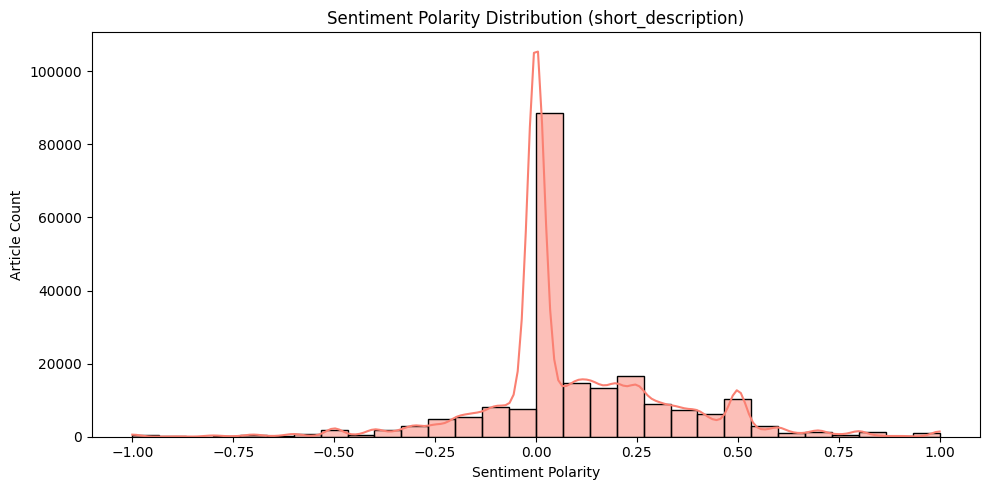

In [43]:
plt.figure(figsize=(10,5))
sns.histplot(df['sentiment_polarity'], bins=30, kde=True, color='salmon')
plt.title("Sentiment Polarity Distribution (short_description)")
plt.xlabel("Sentiment Polarity")
plt.ylabel("Article Count")
plt.tight_layout()
plt.show()

**Insight:**  
- Most news descriptions cluster around neutral sentiment, with some skew towards negative or positive events.


## **Step 4: Named Entity Recognition (NER) with spaCy**

I will extract top named entities (ORG, PERSON, GPE) from news descriptions.

In [20]:
import spacy
from collections import Counter

try:
    nlp = spacy.load("en_core_web_sm")
except:
    import os
    os.system("python -m spacy download en_core_web_sm")
    nlp = spacy.load("en_core_web_sm")

def extract_entities(text, label):
    doc = nlp(str(text))
    return [ent.text for ent in doc.ents if ent.label_ == label]

# Extract named entities for first 500 rows (speed)
entities = {"ORG": [], "PERSON": [], "GPE": []}
for desc in df['description'][:500]:
    for label in entities.keys():
        entities[label].extend(extract_entities(desc, label))

# Top entities
top_orgs = Counter(entities["ORG"]).most_common(8)
top_people = Counter(entities["PERSON"]).most_common(8)
top_places = Counter(entities["GPE"]).most_common(8)

## **Step 5: Display Top Named Entities**

Below are the top organizations, people, and places mentioned in the news descriptions.


In [21]:
print("Top ORGs:", top_orgs)
print("Top PERSONs:", top_people)
print("Top PLACEs:", top_places)

Top ORGs: [('gop', 6), ('senate', 5), ('congress', 4), ('white house', 3), ('fox news', 3), ('fbi', 3), ('the supreme court', 3), ('supreme court', 2)]
Top PERSONs: [('donald trump', 6), ('joe biden', 5), ('graham', 3), ('joe bidens', 3), ('donald trumps', 2), ('chris', 2), ('prince william', 2), ('kate middleton', 2)]
Top PLACEs: [('u.s.', 22), ('new york', 8), ('texas', 7), ('georgia', 5), ('arizona', 4), ('pennsylvania', 4), ('los angeles', 3), ('mississippi', 3)]


**Insight:**  
These named entities highlight the most discussed organizations, individuals, and locations in the dataset, showing what/who dominates news coverage.


## **Step 6: Keyword Extraction with TF-IDF**

We extract top keywords (bigrams) from descriptions using TF-IDF.


In [22]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Use bigrams, English stopwords, min_df=2 for signal
tfidf = TfidfVectorizer(ngram_range=(1,2), stop_words='english', min_df=2)
X = tfidf.fit_transform(df['description'].astype(str))
feature_array = tfidf.get_feature_names_out()
tfidf_scores = X.sum(axis=0).A1
top_n = 10
top_keywords = [feature_array[i] for i in tfidf_scores.argsort()[::-1][:top_n]]

print("Top 10 TF-IDF Keywords/Bigrams:")
for i, kw in enumerate(top_keywords, 1):
    print(f"{i}. {kw}")

Top 10 TF-IDF Keywords/Bigrams:
1. nan
2. new
3. just
4. people
5. time
6. like
7. said
8. dont
9. day
10. know


**Insight:**  
These keywords represent the most characteristic and frequent terms in the news dataset.

## **Step 7: Topic Modeling with LDA**

Apply LDA topic modeling to discover major topics in the dataset.


In [23]:
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer

cv = CountVectorizer(stop_words='english', max_df=0.95, min_df=2)
X_cv = cv.fit_transform(df['description'].astype(str))

lda = LatentDirichletAllocation(n_components=4, random_state=42)
lda.fit(X_cv)

def display_topics(model, feature_names, n_top_words):
    for idx, topic in enumerate(model.components_):
        print(f"Topic {idx+1}: ", " | ".join([feature_names[i] for i in topic.argsort()[:-n_top_words-1:-1]]))

print("\nLDA Topic Modeling – Top Words per Topic:")
display_topics(lda, cv.get_feature_names_out(), 7)


LDA Topic Modeling – Top Words per Topic:
Topic 1:  new | people | health | said | years | week | news
Topic 2:  just | like | time | people | dont | life | said
Topic 3:  new | time | want | check | day | like | just
Topic 4:  nan | trump | donald | trumps | president | good | campaign


**Insight:**  
LDA identifies main underlying themes in the news descriptions, clustering articles by shared vocabulary (e.g., health, politics, world events).

---

# **Section 4 Complete**

- Performed sentiment, NER, and keyword analysis on the news data.
- Visualized and summarized semantic patterns in news descriptions.

I can now use these insights for further modeling, trend analysis, or reporting.


---

# Scaling the ETL & NLP Pipeline for Large Datasets (1M+ Records)

Processing millions of records requires an efficient, memory-conscious approach. Below are strategies and sample code for scaling:

---

## **Step 1: Streaming & Chunk Processing**

**Why:**  
Loading all data into memory at once is not feasible for very large files.  
**How:**  
- **For CSV**: Use pandas' `read_csv()` with `chunksize` to iterate through data in manageable chunks.
- **For JSONL**: Read and process each line (record) sequentially, avoiding full memory load.

### **Example: Processing a Large CSV File in Chunks**


In [24]:
def process_csv_in_chunks(csv_path, chunk_size=10000):
    for chunk in pd.read_csv(csv_path, chunksize=chunk_size):
        cleaned_chunk = clean_chunk(chunk)   # custom cleaning function
        # process or save each chunk (append to disk, DB, etc.)
        yield cleaned_chunk

def clean_chunk(chunk):
    # Modular cleaning steps (e.g., remove nulls, standardize text)
    chunk = chunk.drop_duplicates().dropna(subset=['headline', 'short_description'])
    for col in ['headline', 'short_description', 'category', 'authors']:
        chunk[col] = chunk[col].astype(str).str.strip().str.lower()
    return chunk

# Usage example (writes to a new file chunk by chunk)
'''
large_etl_output = 'path of large csv file'
with open(large_etl_output, 'w', encoding='utf-8') as out_f:
    first = True
    for cleaned in process_csv_in_chunks('large_news.csv'):
        cleaned.to_csv(out_f, header=first, index=False)
        first = False
'''

"\nwith open('large_etl_output.csv', 'w', encoding='utf-8') as out_f:\n    first = True\n    for cleaned in process_csv_in_chunks('large_news.csv'):\n        cleaned.to_csv(out_f, header=first, index=False)\n        first = False\n"

### **Example: Streaming and Writing Large JSONL File**

Process each line individually to keep memory usage low.


In [ ]:
def process_jsonl_stream(input_path, output_path):
    with open(input_path, 'r', encoding='utf-8') as in_f, \
         open(output_path, 'w', encoding='utf-8') as out_f:
        for line in in_f:
            record = json.loads(line)
            cleaned = clean_json_record(record)
            out_f.write(json.dumps(cleaned, ensure_ascii=False) + '\n')

def clean_json_record(record):
    # Example: standardize, remove unwanted fields, etc.
    for k in ['headline', 'short_description', 'category', 'authors']:
        record[k] = str(record.get(k, "")).strip().lower()
    return record
large_news = 'path of Large news json'
large_structured_output = 'large structured outpit file path'
# process_jsonl_stream(large_news, large_structured_output)


## **Step 2: Modularization Using Classes and Functions**

Encapsulate ETL and NLP steps in reusable classes and functions for maintainability, scalability, and testing.

### **Example: ETL Class Skeleton**

In [26]:
class NewsETLPipeline:
    def __init__(self, input_path):
        self.input_path = input_path

    def extract(self):
        # Efficient data extraction logic
        pass

    def transform(self, data):
        # Cleaning and transformation logic
        pass

    def load(self, data, output_path):
        # Write to CSV/JSONL or database
        pass

# Usage
# pipeline = NewsETLPipeline("large_news.jsonl")
# for batch in pipeline.extract():
#     cleaned = pipeline.transform(batch)
#     pipeline.load(cleaned, "output.jsonl")


## **3. Caching and Intermediate Storage**

For expensive NLP steps (sentiment, NER), use **caching**:
- Store intermediate results on disk (as CSV/Parquet/Feather) to resume processing if interrupted.
- Use tools like `joblib`, Redis, or simple file-based checkpointing for partial progress tracking.

---

## **Summary:**
- **Streaming** and **chunked processing** prevent out-of-memory errors.
- **Modular design** (functions/classes) ensures reusability, scalability, and maintainability.
- **Caching** allows safe, resumable processing for long-running NLP analysis.

These strategies allow your pipeline to efficiently process and analyze datasets with millions of records, even on modest hardware or in the cloud.

---
